<a href="https://colab.research.google.com/github/nic-barbara/RobustNeuralNetworks/blob/l4dc25/examples/sandwich_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lipschitz-Bounded Deep Networks for MNIST

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nic-barbara/RobustNeuralNetworks/blob/l4dc25/examples/sandwich_mnist.ipynb)

This notebook contains a tutorial on training Lipschitz-bounded deep networks with the Sandwich Layer from [Wang & Manchester (2023)](https://proceedings.mlr.press/v202/wang23v.html). We'll demonstrate how to train Sandwich networks on the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset, and compare their robustness to targeted adversarial attacks with standard, unconstrained Multi-Layer Perceptrons (MLPs).

This notebook is designed to run in a [Google Colab](https://colab.research.google.com/github/nic-barbara/RobustNeuralNetworks/blob/l4dc25/examples/sandwich_mnist.ipynb) session and is split into the following sections:

0. Package installation and setup.
1. Load the training and test data.
2. Define unconstrained and Lipschitz-bounded models.
3. Define loss functions and performance metrics.
4. Train the models.
5. Evaluate the trained models.
6. Investigate robustness to adversarial attacks.

A single python script with all of the following code is available [here](https://github.com/nic-barbara/RobustNeuralNetworks/blob/l4dc25/examples/sandwich_mnist.py). Note that Sections 1-5 of this notebook are based on the [Flax MNIST tutorial](https://flax.readthedocs.io/en/latest/mnist_tutorial.html), since there are very little changes required to train a Lipschitz-bounded network as opposed to an unconstrained network!

### **Note: Enable the GPU**

We highly recommend running this notebook on a GPU to speed up training and adversarial attack calculation. This is easy to do in Google Colab. Simply:

- Navigate to Runtime→Change runtime type.
- Select a GPU from the list of available Hardware Accelerators.

In [1]:
#@title Import packages

# Clean installation of the robust neural networks package and code
!rm -rf RobustNeuralNetworks/
!git clone -b l4dc25 https://github.com/nic-barbara/RobustNeuralNetworks
!pip install RobustNeuralNetworks/

## Install standard Python packages
import warnings
warnings.filterwarnings('ignore')

# For setting up and training models
import flax.linen as nn
import jax
import jax.numpy as jnp
import optax
from functools import partial

# Data handling
import tensorflow_datasets as tfds
import tensorflow as tf

# Plotting, formatting, and analysis
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from pathlib import Path
from IPython.display import clear_output

# Our implementations of Lipschitz-bounded deep networks (LBDN)
from robustnn import lbdn

# Nicer plot formatting
def startup_plotting(font_size=14, line_width=1.5, output_dpi=600):
    """Edited from https://github.com/nackjaylor/formatting_tips-tricks/"""

    # Default settings
    plt.rcParams.update({
        "lines.linewidth": line_width,

        "axes.grid" : True,
        "axes.grid.which": "major",
        "axes.linewidth": 0.5,
        "axes.prop_cycle": cycler("color", [
            "#0072B2", "#E69F00", "#009E73", "#CC79A7",
            "#56B4E9", "#D55E00", "#F0E442", "#000000"]),

        "errorbar.capsize": 2.5,

        "grid.linewidth": 0.25,
        "grid.alpha": 0.5,

        "legend.framealpha": 0.7,
        "legend.edgecolor": [1,1,1],

        "savefig.dpi": output_dpi,
        "savefig.format": 'pdf'
    })

    # Change default font sizes.
    plt.rc('font', size=font_size)
    plt.rc('axes', titlesize=font_size)
    plt.rc('axes', labelsize=font_size)
    plt.rc('xtick', labelsize=0.8*font_size)
    plt.rc('ytick', labelsize=0.8*font_size)
    plt.rc('legend', fontsize=0.8*font_size)

startup_plotting()
clear_output()

In [2]:
#@title Set up file paths and random seeds

dirpath = Path(__name__).resolve().parent
datapath = dirpath / "data/"

tf.random.set_seed(42)

## 1. Loading the MNIST Dataset

### 1.1 Load the data

Let's start by loading the training and test data. There are a total of 60,000 training images and 10,000 test images in the MNIST dataset, so this will take a minute or so.

In [3]:
train_ds: tf.data.Dataset = tfds.load('mnist', split='train', data_dir=datapath)
test_ds: tf.data.Dataset = tfds.load('mnist', split='test', data_dir=datapath)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /content/data/mnist/incomplete.KO708E_3.0.1/mnist-train.tfrecord*...:   0%|          | 0/60000 [00:0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /content/data/mnist/incomplete.KO708E_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/10000 [00:00…

Dataset mnist downloaded and prepared to /content/data/mnist/3.0.1. Subsequent calls will reuse this data.


### 1.2 Data processing

Each image in the dataset is a $28\times28$-pixel greyscale image of a hand-written number between 0 and 9 (inclusive). We're using MLPs in this example, which operate on 1D vectors rather than 2D images, so we'll do a little bit of data processing before moving on.

In [4]:
def flatten_and_normalise(sample):
    image = sample["image"]
    label = sample["label"]
    image = tf.cast(image, tf.float32) / 255
    image = tf.reshape(image, [-1])
    return {"image": image, "label": label}

# Process data: flatten to 1D vectors and normalise the images
train_ds = train_ds.map(flatten_and_normalise)
test_ds = test_ds.map(flatten_and_normalise)

# Store the sizes for later
n_inputs = 28 * 28      # Images are 28 x 28 pixels each
n_out = 10              # Numbers are 0 to 9, so 10 options

We also need to split the training and test data into a bunch of randomly-shuffled batches that are smaller than the full 60,000-image training data set. We'll then iterate over these batches (for both training and evaluation) while training our models later in this notebook.

In [5]:
# Hyperparameters/data sizes
train_steps = 2000      # Number of training steps to take
eval_every = 100        # How often to evaluate during training
batch_size = 128        # Training batch size
test_batch_size = 256   # Test batch size

# Sort the training and test datasets into batches of appropriate sizes.
# This also shuffles the order of the training data to remove any biases.
train_ds = train_ds.repeat().shuffle(1024, seed=42)
train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)
test_ds = test_ds.batch(test_batch_size, drop_remainder=True).prefetch(1)

## 2. Define Unconstrained and Lipschitz-Bounded Models

A standard way to define a Multi-Layer Perceptron (MLP) in Flax is as follows.

In [6]:
class UnconstrainedMLP(nn.Module):
    """A simple MLP model."""

    def setup(self):
      self.linear1 = nn.Dense(64)       # Layer 1 has 64 hidden neurons
      self.linear2 = nn.Dense(64)       # Layer 2 has 64 hidden neurons
      self.linear3 = nn.Dense(n_out)    # Layer 3 has n_out=10 outputs (one for each number)

    def __call__(self, x):
        x = nn.relu(self.linear1(x))
        x = nn.relu(self.linear2(x))
        x = self.linear3(x)
        return x

With our package, we can create Lipschitz-bounded models with a very similar setup. In the following code cell, we'll create an MLP with a prescribed upper bound of $\gamma$ on its Lipschitz constant using the 1-Lipschitz Sandwich layer. The structure of the network is shown below:

<img src="https://github.com/nic-barbara/RobustNeuralNetworks/blob/l4dc25/examples/assets/lipschitz_network.drawio.png?raw=1" alt="drawing" width="600"/>

The only differences with the standard, `UnconstrainedMLP` above are as follows:
- We use the 1-Lipschitz `SandwichLayer` rather than the standard `Dense` layer.
- Activation functions are included directly in the `SandwichLayer` and don't need to be applied externally.
- To enforce a Lipschitz upper-bound of $\gamma$, we multiply both the network inputs and outputs by $\sqrt{\gamma}$, since the `SandwichLayer`s are all 1-Lipschitz.

In [7]:
class LipschitzMLP(nn.Module):
    """A simple Lipschitz-bounded MLP built with Sandwich layers."""
    gamma: jnp.float32 = 1.0 # type: ignore

    def setup(self):
      self.sandwich1 = lbdn.SandwichLayer(n_inputs, 64, activation=nn.relu)
      self.sandwich2 = lbdn.SandwichLayer(64, 64, activation=nn.relu)
      self.sandwich3 = lbdn.SandwichLayer(64, n_out, is_output=True)
      self.scale = jnp.sqrt(self.gamma)

    def __call__(self, x):
        x = self.scale * x
        x = self.sandwich1(x)
        x = self.sandwich2(x)
        x = self.sandwich3(x)
        x = self.scale * x
        return x

We'll choose a Lipschitz bound of $\gamma = 2.0$ for this example. We can think of $\gamma$ as a tuning parameter. The smaller we make $\gamma$, the greater the regularisation on the network to smooth its response to input perturbations. This will improve robustness up to a point, but be careful not to overdo it! If the Lipschtiz bound $\gamma$ is too small, it will severely affect performance, just like any other regularisation tool.

In [8]:
model_mlp = UnconstrainedMLP()
model_lip = LipschitzMLP(gamma=2.0)

## 3. Define Loss Function and Performance Metrics

Now that we've constructed our models, it's almost time to train them. To do so, we need to define a loss function to be minimised, and some useful performance metrics to keep track of the classification accuracy. We'll also define a wrapper function to make predictions once we've trained a model.

In [9]:
# Loss function: standard cross-entropy loss for image classification
def get_loss(logits, labels):
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    return loss.mean()

# Compute classification accuracy
def compute_accuracy(logits, labels):
    return 100 * jnp.mean(jnp.argmax(logits, axis=-1) == labels)

# Helper function to make predictions on a batch of data given a model and its learnable parameters
@partial(jax.jit, static_argnums=0)
def predict(model, params, batch):
    logits = model.apply(params, batch['image'])
    return logits.argmax(axis=1)

## 4. Train the Models

We're ready to train our models, which we do with the function below. Note that it's exactly the same for both the unconstrained and Lipschitz-bounded MLPs! Feel free to expand the cell to see how the function is constructed. As a summary, it takes a `model` and:
- Randomly initialises a set of learnable parameters for the model.
- Sets up an optimiser for gradient descent using [Adam](https://arxiv.org/abs/1412.6980).
- Defines just-in-time compiled functions with JAX that efficiently compute the loss and apply a single step of gradient descent.
- Runs the training loop over `training_steps` epochs, logging the test loss and accuracy every `eval_every` steps.

In [10]:
#@title The `train_mnist_classifier` function

def train_mnist_classifier(model, seed=42, verbose=True):

    # Initialise the model parameters
    rng = jax.random.key(seed)
    inputs = jnp.ones((1, n_inputs), jnp.float32)
    params = model.init(rng, inputs)

    # Set up the optimiser
    optimizer = optax.adam(learning_rate=0.005)
    opt_state = optimizer.init(params)

    # Loss function
    @jax.jit
    def loss_fn(params, batch):
        logits = model.apply(params, batch['image'])
        loss = get_loss(logits, batch['label'])
        return loss, logits

    # A single training step
    @jax.jit
    def train_step(params, opt_state, batch):
        grad_fn = jax.grad(loss_fn, has_aux=True)
        grads, _ = grad_fn(params, batch)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state

    # Train over many batches and log test accuracy
    metrics = {"step": [], "test_accuracy": []}
    for step, batch in enumerate(train_ds.as_numpy_iterator()):

        # Run the optimiser for one step
        params, opt_state = train_step(params, opt_state, batch)

        # Log metrics intermittently
        if step == 0 or (step % eval_every == 0 or step == train_steps - 1):
            batch_accuracy = []
            for test_batch in test_ds.as_numpy_iterator():
                _, test_logits = loss_fn(params, test_batch)
                acc = compute_accuracy(test_logits, test_batch["label"])
                batch_accuracy.append(acc)
            metrics["step"].append(step)
            metrics["test_accuracy"].append(np.mean(batch_accuracy))

            # Print the results to inform the user
            if verbose:
                print(f"Training step: {step}\tTest accuracy (%): {metrics['test_accuracy'][-1]:.2f}")

    return params, metrics

Training the models is then as simple as running the function for each architecture.

In [11]:
params_mlp, metrics_mlp = train_mnist_classifier(model_mlp, verbose=True) # Train unconstrained
params_lip, metrics_lip = train_mnist_classifier(model_lip, verbose=True) # Train Lipschitz

Training step: 0	Test accuracy (%): 33.02
Training step: 100	Test accuracy (%): 91.96
Training step: 200	Test accuracy (%): 93.03
Training step: 300	Test accuracy (%): 95.33
Training step: 400	Test accuracy (%): 95.55
Training step: 500	Test accuracy (%): 95.66
Training step: 600	Test accuracy (%): 95.65
Training step: 700	Test accuracy (%): 95.72
Training step: 800	Test accuracy (%): 96.20
Training step: 900	Test accuracy (%): 96.07
Training step: 1000	Test accuracy (%): 95.51
Training step: 1100	Test accuracy (%): 96.04
Training step: 1200	Test accuracy (%): 96.45
Training step: 1300	Test accuracy (%): 96.55
Training step: 1400	Test accuracy (%): 96.48
Training step: 1500	Test accuracy (%): 96.22
Training step: 1600	Test accuracy (%): 97.16
Training step: 1700	Test accuracy (%): 97.02
Training step: 1800	Test accuracy (%): 96.61
Training step: 1900	Test accuracy (%): 95.96
Training step: 1999	Test accuracy (%): 97.11
Training step: 0	Test accuracy (%): 17.66
Training step: 100	Test a

## 5. Evaluate the Trained Models

Plotting the test accuracy during training shows that both the unconstrained and Lipschitz-bounded MLPs reach a similar final test accuracy and train at a similar rate.

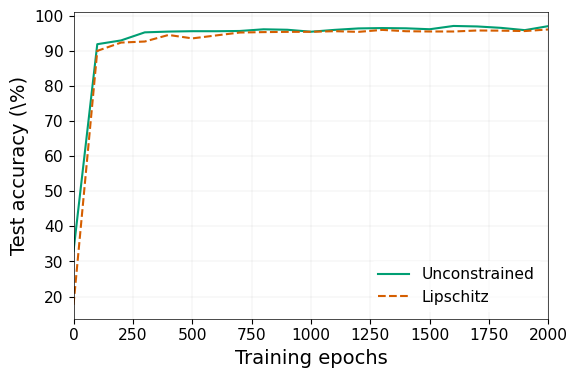

In [12]:
color_mlp = "#009E73"
color_lip = "#D55E00"

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(metrics_mlp["step"], metrics_mlp["test_accuracy"], color=color_mlp, label="Unconstrained")
ax.plot(metrics_lip["step"], metrics_lip["test_accuracy"], "--", color=color_lip, label="Lipschitz")
ax.set_xlabel("Training epochs")
ax.set_ylabel("Test accuracy (\%)")
ax.set_xlim(0, train_steps)
ax.legend(loc="lower right")
plt.tight_layout()

We can also have a look at a few examples of their classification results below. As we can see, both networks correctly classify most of the numbers in the test dataset.

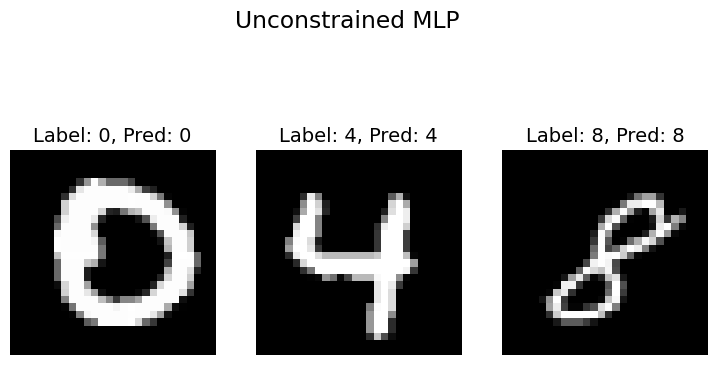

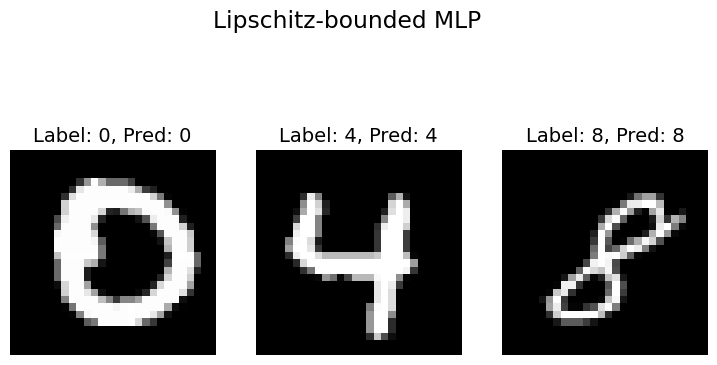

In [13]:
#@title Visualise predictions on the test dataset

def plot_mnist_results(test_batch, pred, name):

    fig, axs = plt.subplots(1, 3, figsize=(9, 5))
    for i, ax in enumerate(axs.flatten()):

        # Reshape image again for plotting
        i = i + 1   # Choose nice examples
        label = test_batch['label'][i]
        image = test_batch['image'][i]
        image = jnp.reshape(image, (28, 28))

        # Plot the number
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Label: {label}, Pred: {pred[i]}")
        ax.axis('off')
        fig.suptitle(name)
    plt.show()

# Run the predictions
test_batch = test_ds.as_numpy_iterator().next()
pred_mlp = predict(model_mlp, params_mlp, test_batch)
pred_lip = predict(model_lip, params_lip, test_batch)

# Plot the predictions
plot_mnist_results(test_batch, pred_mlp, "Unconstrained MLP")
plot_mnist_results(test_batch, pred_lip, "Lipschitz-bounded MLP")

## 6. Investigate Robustness to Adversarial Attacks

So far, there hasn't been much difference between the unconstrained and Lipschitz-bounded MLP models. The advantage of the Lipschitz bound becomes most clear when testing the robustness of the models to input perturbations, such as those generated by targeted adversarial attacks.

The following function takes a model, its trained parameters, and computes the optimal noise (via gradient ascent) that can be added to the image to trick the classifier into making an incorrect prediction. Rather than letting the attacker have an unlimited attack budget (in which case it could just change all the pixels in the image), we constrain the perturbation to have a maximum $\ell_2$-norm of some `attack_size`.

In [14]:
#@title Adversarial attack function.

# Compute l2-optimal adversarial attacks with projected gradient descent.
def pgd_attack(
    model,
    params,
    test_batch,
    attack_size=1,
    max_iter=500,
    learning_rate=0.01,
    seed=42
):

    # Edge case
    if attack_size == 0:
        return jnp.zeros(test_batch["image"].shape), test_batch

    # Define how to constrain attack size (l2 norm)
    def project_attack(attack, attack_size):
        attack = attack / jnp.linalg.norm(attack, axis=-1, keepdims=True)
        return attack_size * attack

    # Initialise an attack
    rng = jax.random.key(seed)
    rng, key1 = jax.random.split(rng)
    attack = jax.random.uniform(key1, test_batch["image"].shape)
    attack = (project_attack(attack, attack_size),)

    # Set up the optimizer
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(attack)

    # Loss function
    @jax.jit
    def loss_fn(attack, batch):
        attack = project_attack(attack[0], attack_size)
        attacked_image = batch['image'] + attack
        logits = model.apply(params, attacked_image)
        return -get_loss(logits, batch['label'])

    # A single attack step with projected gradient descent
    @jax.jit
    def attack_step(attack, opt_state, batch):
        grad_fn = jax.grad(loss_fn)
        grads = grad_fn(attack, batch)
        updates, opt_state = optimizer.update(grads, opt_state)
        attack = optax.apply_updates(attack, updates)
        return attack, opt_state

    # Use gradient descent to estimate the Lipschitz bound
    for _ in range(max_iter):
        attack, opt_state = attack_step(attack, opt_state, test_batch)

    # Return the attack and the perturbed image
    attack = project_attack(attack[0], attack_size)
    attack_batch = {"image": test_batch["image"] + attack,
                      "label": test_batch["label"]}
    return attack, attack_batch

Let's compute the optimal attack for a range of `attack_size`s and see how it affects the test error of our unconstrained and Lipschitz-bounded MNIST classifiers. The following code cell might take a couple of minutes to run, but can be sped up by increasing the `attack_resolution` parameter.

Plotting our results below reveals that the Lipschitz-bounded models are significantly more robust to $\ell_2$-constrained adversarial attacks than the unconstrained MLP models. This is the advantage of a Lipschitz bound, since it directly constrains the sensitivity of the network to small input perturbations. This forces the attacker to use larger attacks to degrade the classification accuracy to similar levels as the unconstrained MLP at smaller attack sizes.

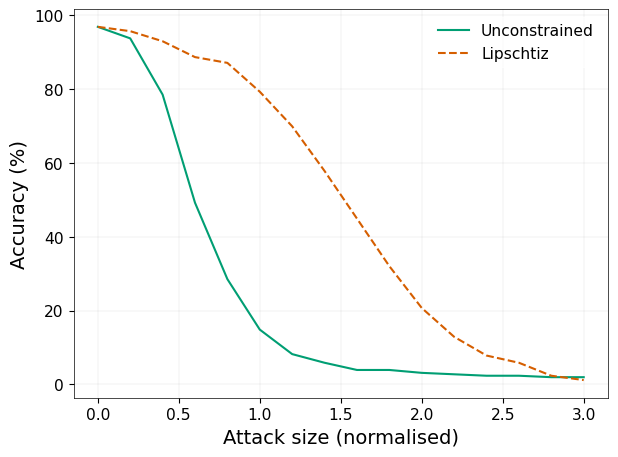

In [15]:
def attacked_test_error(model, params, test_batch, attack_size):
    _, attack_batch = pgd_attack(model, params, test_batch, attack_size)
    logits = model.apply(params, attack_batch['image'])
    labels = test_batch["label"]
    return 100 * jnp.mean(jnp.argmax(logits, axis=-1) == labels)

# Run the attacks
attack_resolution = 0.2
attack_sizes = jnp.arange(0, 3 + attack_resolution, attack_resolution)
acc_mlp = []
acc_lip = []
for a in attack_sizes:
    acc_mlp.append(attacked_test_error(model_mlp, params_mlp, test_batch, a))
    acc_lip.append(attacked_test_error(model_lip, params_lip, test_batch, a))

# Plot the results
plt.plot(attack_sizes, acc_mlp, color=color_mlp, label="Unconstrained")
plt.plot(attack_sizes, acc_lip, "--", color=color_lip, label="Lipschtiz")
plt.xlabel("Attack size (normalised)")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()

We can dig a little deeper here too. Let's take a look at what sort of attacks are required to reduce the MLP accuracy to about 20%. We can see that even with faint background noise, the classification performance can be completely destroyed.

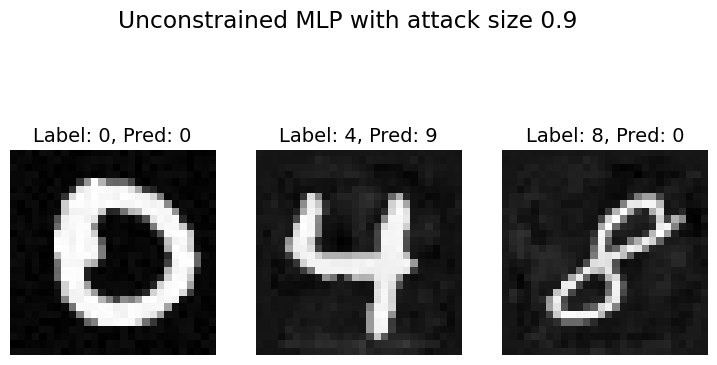

In [16]:
attack_size = 0.9
_, attack_batch_mlp = pgd_attack(model_mlp, params_mlp, test_batch, attack_size)
pred_mlp = predict(model_mlp, params_mlp, attack_batch_mlp)
plot_mnist_results(attack_batch_mlp, pred_mlp, f"Unconstrained MLP with attack size {attack_size}")

In contrast, the attacks for the attacks for the Lipschitz-bounded network not only need to be larger to degrade the model's classification accuracy to about 20%, but they also need to be clearly structured. In the example below, the attacker tries to complete the top of the digit `4` to turn it into a `9`, which is what the model predicts. Similarly, we see a faint outline of a `3` behind the `8` to trick the Lipschitz-bounded classifier.

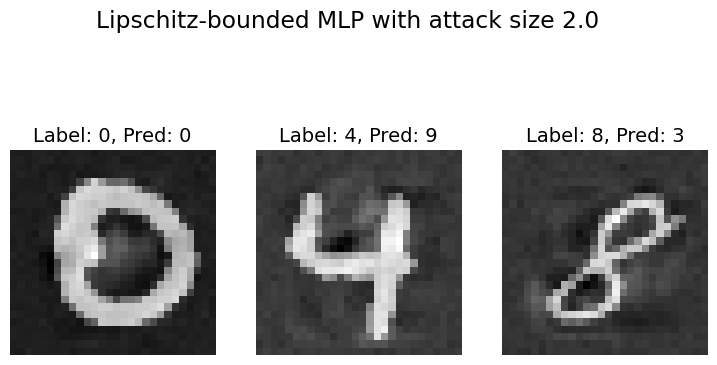

In [17]:
attack_size = 2.0
_, attack_batch_lip = pgd_attack(model_lip, params_lip, test_batch, attack_size)
pred_lip = predict(model_lip, params_lip, attack_batch_lip)
plot_mnist_results(attack_batch_lip, pred_lip, f"Lipschitz-bounded MLP with attack size {attack_size}")

## 7. Conclusion

In summary, we have illustrated that Lipschitz-bounded models are far more robust to input perturbations, even those generated by targeted adversarial attacks, than traditional unconstrained models. Moreover, substituting a Lipschitz-bounded Sandwich network for an uncosntrained MLP is as simple as swapping out the layer architecture in the model definition. Everything else, from data handling to training to model evaluation, is exactly the same.